# Problem 1: Bayesian Density Estimation
By: Griffin Hosseinzadeh (2025 May 6)  
Inspired by a notebook by LM Walkowicz (2019 June 14)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization as viz
from scipy import stats
from sklearn.neighbors import KernelDensity
from george import kernels

Here I'm simulating some data. Just run this cell to generate a list of values `x`.

In [66]:
x = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
x = x[(x > -15) & (x < 15)]
print(list(x))

[np.float64(-4.819321497504487), np.float64(-10.01887281284387), np.float64(-6.271640464944646), np.float64(-1.8779833149267477), np.float64(-4.361945681233723), np.float64(-6.827063515484029), np.float64(-4.390432804524156), np.float64(-5.940317662113912), np.float64(-7.027881965064428), np.float64(-5.632074136657385), np.float64(-2.173766195512103), np.float64(-9.241896695441206), np.float64(-2.787222262746716), np.float64(-5.582811354825901), np.float64(-4.064812337745161), np.float64(-4.028831401718365), np.float64(2.4103351322662716), np.float64(-5.844842770463439), np.float64(-9.98593609985467), np.float64(-5.8775671348199605), np.float64(3.096606316096361), np.float64(6.173889483287052), np.float64(-2.736800732784481), np.float64(-6.190060398791415), np.float64(-8.259000131945056), np.float64(-5.850204141827326), np.float64(-8.14236511504211), np.float64(-5.28764854259506), np.float64(-1.2784461673630743), np.float64(-0.705207692927412), np.float64(-2.118291785082145), np.float6

Make a histogram of these values using `plt.hist`. (Use `density=True` throughout this exercise, so the y-axes are comparable.) How many peaks does this data set have?

It has 10

(array([0.00272063, 0.0052858 , 0.02153187, 0.11792004, 0.06925956,
        0.06723852, 0.03746701, 0.00831737, 0.00365342, 0.00178785]),
 array([-14.97478415, -11.99133119,  -9.00787822,  -6.02442526,
         -3.0409723 ,  -0.05751934,   2.92593363,   5.90938659,
          8.89283955,  11.87629251,  14.85974548]),
 <BarContainer object of 10 artists>)

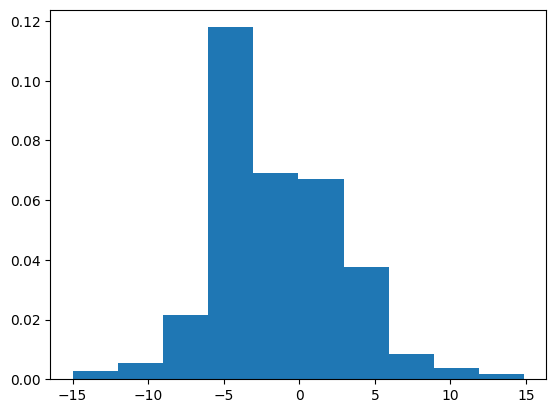

In [67]:
plt.hist(x, density = True)  # complete

Now make a histogram using the `'auto'` binning in Matplotlib. What does it think the right number of bins should be? How many peaks does this data set have?

41 bins


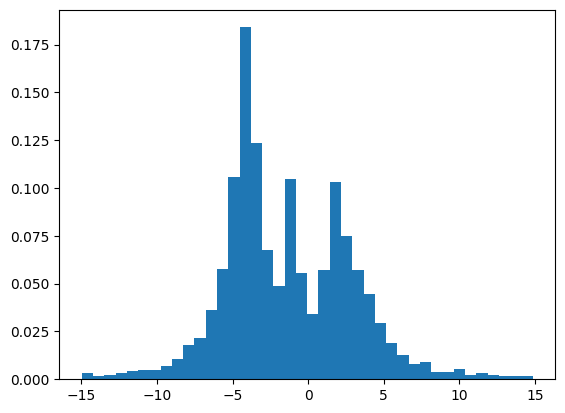

In [68]:
n, b, p = plt.hist(x, density=True, bins = "auto") # complete
print(len(b), 'bins')

Increase the number of bins even further. Is there a point where it gets too high? If so, why?

With 100000 bins it looks like spikes.

In [69]:
#plt.hist(x, bins = 100000, density = True )  # complete

Now make a histogram using Bayesian blocks. Hint: try the `astropy.visualization.hist` function. How many bins does this have? Can you see all the peaks?

20 bins


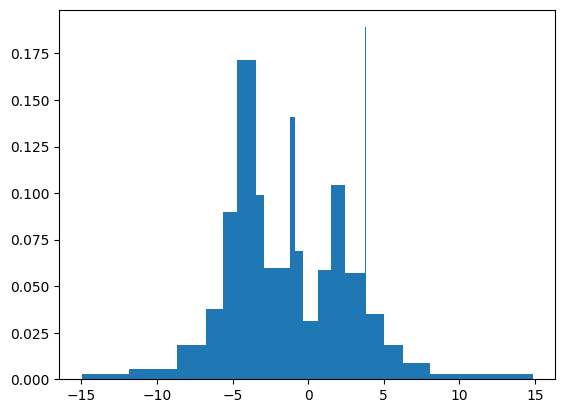

In [70]:
n, b, p = viz.hist(x, density = True, bins = "blocks")  # complete
print(len(b), 'bins')

Try making the Bayesian blocks histogram *without* `density=True`. What do you notice? Is this a good idea?

No this is not a good idea because it spreads out the edge bins.

20 bins


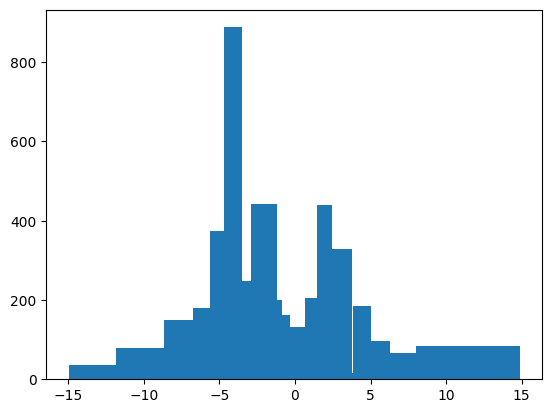

In [71]:
n, b, p = viz.hist(x, bins = "blocks")  # complete
print(len(b), 'bins')

Now let's try making a KDE instead. Try a few different values for the bandwidth until you find one you like.

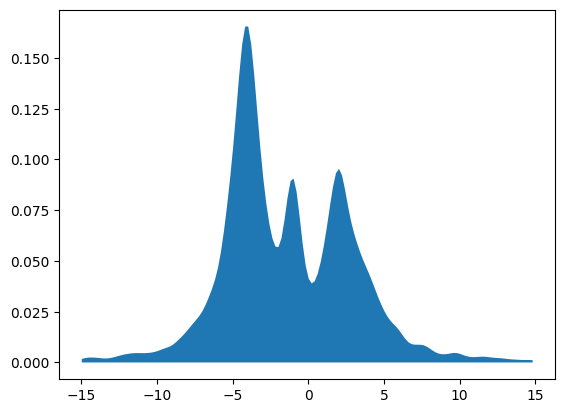

In [72]:
x = x.reshape(-1,1)

kde = KernelDensity(kernel = "gaussian", bandwidth=0.4)
kde.fit(x)  # complete

x_fit = np.arange(x.min(), x.max(), 0.2).reshape(-1,1)# complete

log_dens = kde.score_samples(x_fit) 
y_fit = np.exp(log_dens) 

plt.fill_between(x_fit.ravel(), y_fit)  # complete

Plot all of these density estimates on top of each other using `histtype='step'` and compare them.

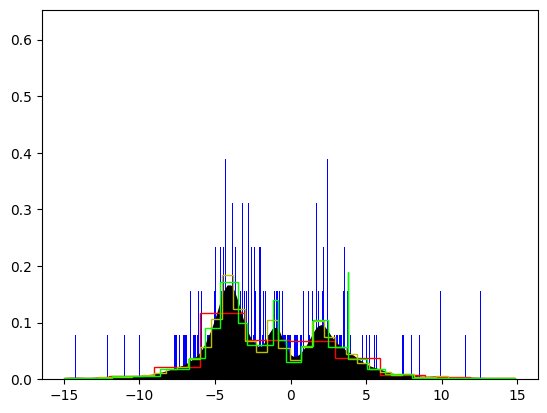

In [73]:
plt.hist(x, density = True, histtype='step', color ="r")  # complete
n1, b1, p1 = plt.hist(x, density=True, bins = "auto", histtype='step', color = "y") # complete
plt.hist(x, bins = 10000, density = True, color ="b")  # complete
n2, b2, p2 = viz.hist(x, density = True, bins = "blocks", histtype='step', color = "lime")  # complete
#n3, b3, p3 = viz.hist(x, bins = "blocks",histtype='step')  # complete
plt.fill_between(x_fit.ravel(), y_fit, color = "black")  # complete



# Problem 2: Gaussian Process Regression
By: Griffin Hosseinzadeh (2019 April 17)  
Updated 2025 May 6

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import george
from astropy.table import Table

## Read the Light Curve
I have given you light curve data for the Type Ibn supernova PTF11rfh in the file `PTF11rfh.table`, which is readable with the `astropy.table` module. (Hint: `format='ascii.fixed_width'`.) For this example, let's fit the light curve in counts rather than magnitudes. Select only points observed in the $r$ or $R$ filter and have a measurement in counts. Plot it to see what we're working with. (For non-astronomers, MJD is a measure of time in days.)

In [75]:
data = Table.read("PTF11rfh.table", format='ascii.fixed_width')  # complete
clean_data = data[~data["counts"].mask]

#print(clean_data)
#print(data.colnames)
# for i in range(len(clean_data)):
#     print(clean_data[:i])
    
filt = np.isin(clean_data["filt"],["r","R"])
filt_table = clean_data[filt]


Text(0, 0.5, '$Counts$')

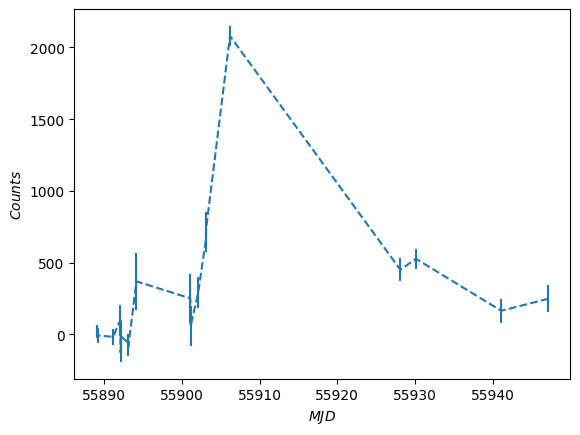

In [76]:
x_lc = filt_table["MJD"]  # complete
#print(len(x_lc))
y_lc = filt_table["counts"]  # complete
#print(len(y_lc))
dy_lc = filt_table["dcounts"]  # complete

plt.errorbar(x_lc, y_lc, yerr = dy_lc, fmt = "--")
plt.xlabel(r"$MJD$")
plt.ylabel(r"$Counts$")   

## Try a Polynomial Fit
Hint: use `np.polyfit` and `np.polyval`. Try different degree polynomials to see if you are able to get a good fit.

C:\Users\young\AppData\Local\Temp\ipykernel_8036\3638146956.py:5: RankWarning: Polyfit may be poorly conditioned
  y_fit_poly = np.polyfit(x_fit, y_lc, 8)  # complete


Text(0, 0.5, '$Counts$')

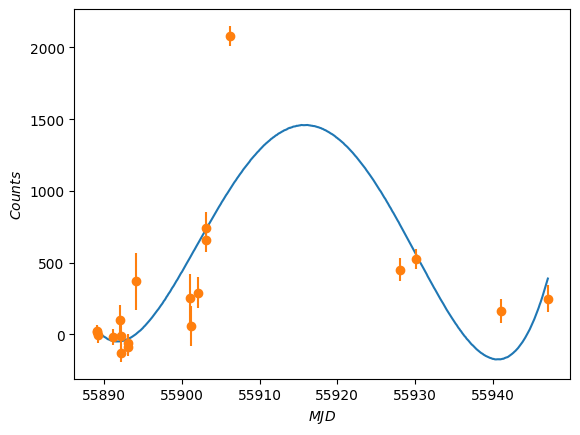

In [77]:
x_fit = x_lc# complete

# complete
x_pred_pf = np.linspace(x_lc.min(), x_lc.max(), 500)
y_fit_poly = np.polyfit(x_fit, y_lc, 8)  # complete
y_vals = np.polyval(y_fit_poly, x_pred_pf)
plt.plot(x_pred_pf, y_vals)
plt.errorbar(x_lc, y_lc, yerr = dy_lc, fmt = "o")
plt.xlabel(r"$MJD$")
plt.ylabel(r"$Counts$")   
# plot
# plot
# plot
# plot
# plot

Don't spend too much time on this. I could not get it to give a reasonable result.

## Try a Gaussian Process
We are using a package called `george` to make Gaussian process regression easier. It has all of the functions you need build in.

First we need to initialize a kernel (`george.kernels`). You should normalize the kernel by the total variance of the data points. Think about what hyperparameters would be appropriate for fitting your data. We can always optimize them later.

In [78]:
kernels = george.kernels

kernel = np.var(y_lc) * kernels.ExpSquaredKernel(80)

Initialize a Gaussian process with the kernel you chose. This is all contained within the `george.GP` object, which we will use for the remainder of the calculations.

In [79]:
gp = george.GP(kernel) # complete
x_pred = np.linspace(x_lc.min(), x_lc.max(), 500)

The first step is to precompute the covariance matrix at the observed times.

In [80]:
gp.compute(x_lc, dy_lc)

The second and last step is to use the Gaussian process to predict the light curve at the times in `x_fit`, given the observed data points in `y`. This should give you an interpolation **and** and uncertainty on the interpolation.

In [81]:
pred, pred_var = gp.predict(y_lc, x_pred, return_var=True)
#print(x_pred)
#print(pred)
#print(pred_var)

Plot the results of your Gaussian process fit and compare to the data and the polynomial fit. Hint: display the uncertainties using `plt.fill_between`.

Text(0, 0.5, '$Counts$')

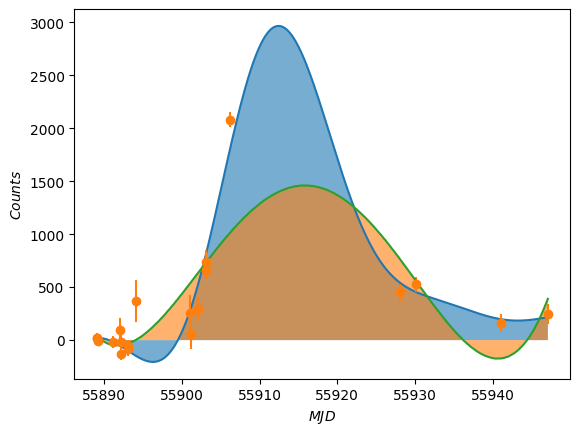

In [83]:
plt.plot(x_pred, pred)
plt.errorbar(x_lc, y_lc, yerr = dy_lc, fmt = "o")
plt.fill_between(x_pred, pred, alpha = 0.6)
plt.plot(x_pred_pf, y_vals)
plt.fill_between(x_pred_pf, y_vals, alpha = 0.6)
plt.xlabel(r"$MJD$")
plt.ylabel(r"$Counts$")   

Once you get a reasonable fit, try adjusting the kernel and/or hyperparameters to see what effects they have.

## Take-Away Message
Gaussian process regression is a very easy and powerful way to interpolate an arbitrary set of data points with a nonparametric function. Furthermore, it gives you uncertainties on the interpolation and handles covariance between points correctly.

## Other Things to Try (Optional)
- Optimize the Gaussian process using the technique described in the George tutorial: https://george.readthedocs.io/en/latest/tutorials/first/.
- Marginalize over the hyperparameter(s) using MCMC.
- Try products of different kernels to see if you can get a better fit.